In [ ]:
from analysis_lib import KeysightInfiniiVisionMSO, BrotherSerialDecoder, plot_digital, DEFAULT_LABELS
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

ADDRESS = "USB0::2391::5925::MY49110266::INSTR"

def setup_scope(time_scale=1.5e-4, delay=4.5e-4, trigger_channel=4, trigger_slope="NEGative"):
    """
    Quick scope setup for notebook use
    """
    scope = KeysightInfiniiVisionMSO(ADDRESS)

    scope.setup_digital_channels(
        channels=range(6),
        threshold=2.5,
        time_scale=time_scale,
    )

    for i, label in enumerate(DEFAULT_LABELS):
        scope.set_digital_label(i, label)

    scope.setup_digital_trigger(channel=trigger_channel, slope=trigger_slope)
    scope.set_trigger_delay(delay)

    return scope

In [2]:
# Capture One Letter U

import serial
import time

with setup_scope(time_scale=0.25e-4, delay=1e-4, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:
        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(0.2)

        # Now send serial data
        con.write(bytes([0x55])) # Send Uppercase Letter U
        time.sleep(0.2)

        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1)

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Connection closed


In [ ]:
from analysis_lib import RawDecoder, BrotherSerialDecoder, plot_digital

# Decode raw frames (defaults: clock_ch=2, ready_ch=4)
raw_decoder = RawDecoder(channel_data, time_data)
raw_si, raw_so = raw_decoder.decode(data_ch=[0, 1])

# Decode Brother protocol
decoded_si = BrotherSerialDecoder(raw_si).decode()
decoded_so = BrotherSerialDecoder(raw_so).decode()

# Plot with annotations
annotations = (
    decoded_si.to_annotations(include_bits=True) +
    decoded_so.to_annotations(include_bits=True)
)
plot_digital(time_data, channel_data, annotations=annotations)

# Print decoded values
print(f"SI: {decoded_si.as_hex_string()}")
print(f"SO: {decoded_so.as_hex_string()}")

In [11]:
# Capture Select

import serial
import time

with setup_scope(time_scale=0.2e-2, delay=0.8e-2, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:
        # Setup
        con.write(bytes([0x13])) # DC3 Put IF-60 into Deselected State
        time.sleep(2)

        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(0.5)

        # DC1 Put IF-60 into Select State
        con.write(bytes([0x11]))
        time.sleep(3)

        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='RAW')

        # CR to return Carriage
        con.write(bytes([0x0D]))
        # DC3 Put IF-60 into Deselected State
        con.write(bytes([0x13]))

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Connection closed


In [ ]:
from analysis_lib import RawDecoder, BrotherSerialDecoder, plot_digital

# Decode raw frames (defaults: clock_ch=2, ready_ch=4)
raw_decoder = RawDecoder(channel_data, time_data)
raw_si, raw_so = raw_decoder.decode(data_ch=[0, 1])

# Decode Brother protocol
decoded_si = BrotherSerialDecoder(raw_si).decode()
decoded_so = BrotherSerialDecoder(raw_so).decode()

# Plot with annotations
annotations = (
    decoded_si.to_annotations(include_bits=True) +
    decoded_so.to_annotations(include_bits=True)
)
plot_digital(time_data, channel_data, annotations=annotations)

# Print decoded values
print(f"SI: {decoded_si.as_hex_string()}")
print(f"SO: {decoded_so.as_hex_string()}")

In [15]:
# Capture small abc

import serial
import time

with setup_scope(time_scale=8e-3, delay=32e-3, trigger_slope="NEGative") as scope:
    with serial.Serial(
        port='/dev/ttyUSB0',
        baudrate=9600,
        bytesize=serial.EIGHTBITS,    # Data Bits: 8
        stopbits=serial.STOPBITS_ONE, # Stop Bits: 1
        parity=serial.PARITY_NONE,    # Parity: None
        rtscts=True,                  # Hardware handshake
        timeout=1
    ) as con:

        # Arm the trigger (non-blocking)
        scope.arm_trigger()
        time.sleep(0.5)

        # Send small case alphabet
        con.write(b'abcdefghijklmnopqrstuvxyz')
        time.sleep(4)

        # Read the captured data
        time_data, packed, channel_data = scope.read_current_pod_data(pod=1, mode='RAW')

Connected to: AGILENT TECHNOLOGIES,MSO7014A,MY49110266,06.20.0000
Digital channels [0, 1, 2, 3, 4, 5] enabled, threshold=2.5V
Edge trigger on D4, slope=NEGative
Connection closed


2400000
Plotter Ch0: Found 24 bytes / 192 bits.
Plotter Ch1: Found 24 bytes / 192 bits.


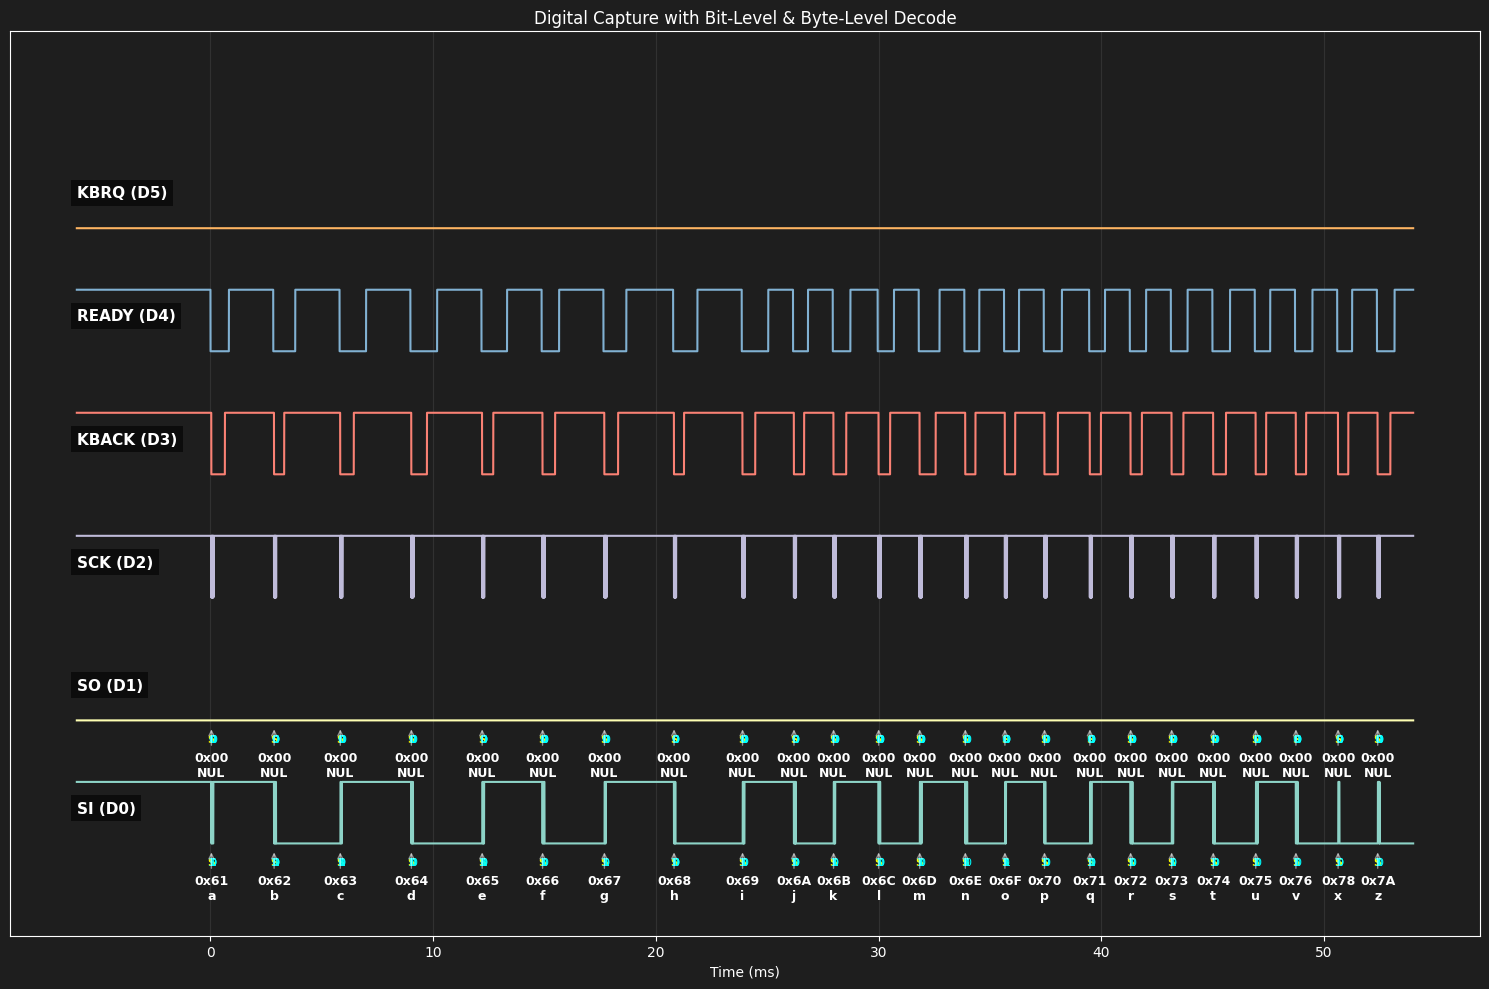

In [16]:
# Plot abc Measurement
plot_with_decode(time_data, channel_data, range(6))

In [ ]:
import pickle
from pathlib import Path
from analysis_lib import RawDecoder, BrotherSerialDecoder, plot_digital

# Load and unpack the variables from signal-captures directory
capture_file = Path('signal-captures/U_Capture.pkl')
with open(capture_file, 'rb') as f:
    time_data, packed, channel_data = pickle.load(f)

# Decode raw frames (defaults: clock_ch=2, ready_ch=4)
raw_decoder = RawDecoder(channel_data, time_data)
raw_si, raw_so = raw_decoder.decode(data_ch=[0, 1])

# Decode Brother protocol
decoded_si = BrotherSerialDecoder(raw_si).decode()
decoded_so = BrotherSerialDecoder(raw_so).decode()

# Plot with annotations
annotations = (
    decoded_si.to_annotations(include_bits=True) +
    decoded_so.to_annotations(include_bits=True)
)
plot_digital(time_data, channel_data, annotations=annotations)

# Print decoded values
print(f"SI: {decoded_si.as_hex_string()}")
print(f"SO: {decoded_so.as_hex_string()}")